# Project at Computer Graphics: Edge Detection


In this project I will be implementing the Canny algorithm for edge detection in images for the first avaliation of the discipline Introdução a Computação Gráfica at FGV. 

In [1]:
from PIL import Image
import numpy as np
from IPython.display import display

## Abrindo a imagem e obtendo seu .data

In [2]:
%%html
<img src = "gato-caixa-areia.jpg" width = "600px"></img>

In [3]:
im = Image.open('gato-caixa-areia.jpg')
data = np.array(im.getdata())
print('Tamanho da imagem em pixels:')
print(im.width, 'x', im.height)
print('Tamanho do nosso array de pixels:')
print(data.shape)

Tamanho da imagem em pixels:
712 x 475
Tamanho do nosso array de pixels:
(338200, 3)


## Tornando a imagem em grayscale

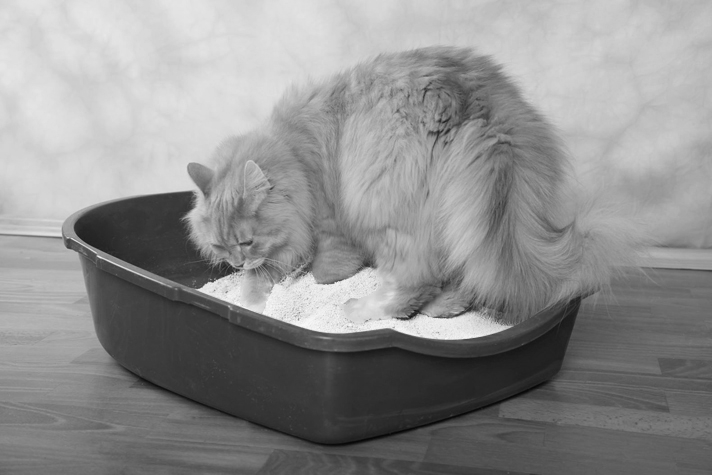

In [4]:
for i in range(len(data)):
    data[i][0] = data[i][1] = data[i][2] = int(data[i].mean())
data = data.reshape(475,712, 3).astype(np.uint8)
gray_scale = Image.fromarray(data)
display(gray_scale)

## Aplicando o filtro gaussiano

In [5]:
def gaussian_func(x,y, sigma):
    val = (np.pi*2*sigma**2)
    e = -(((x-2)**2+(y-2)**2)/(2*sigma**2))
    return np.exp(e)/val

def filtro_gaussiano(sigma, data):
    x, y = np.mgrid[0:5,0:5]
    gauss_mat = np.round(gaussian_func(x,y,1)*343)
    coef = 343
    ans = np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ans[i][j][0] = ans[i][j][1] = ans[i][j][2] = np.round(convolution(gauss_mat, data, i, j)/coef)
    return ans

def convolution(matriz_coef, data, x, y):
    ans = np.zeros((5,5))
    for i in range(x-2,x+3):
        for j in range(y-2,y+3):
            if (0<=i<=474) and (0<=j<=711):
                ans[i+2-x][j+2-y] = matriz_coef[i+2-x][j+2-y]*data[i][j][1]
            else:
                ans[i+2-x][j+2-y] = matriz_coef[i+2-x][j+2-y]*data[x][y][1]
    return sum(sum(ans))

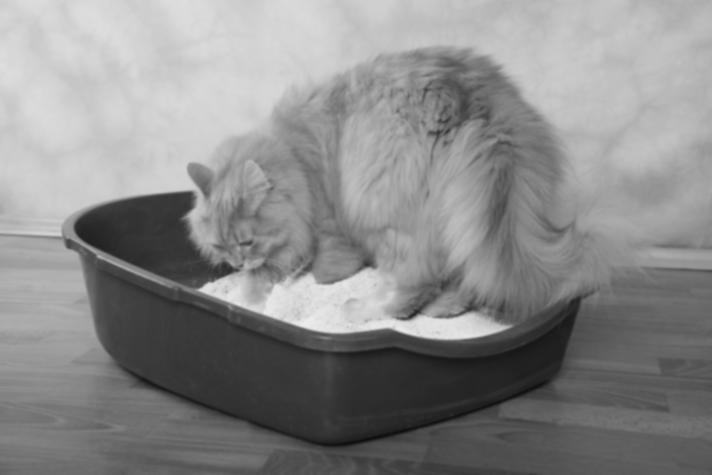

In [6]:
data1 = filtro_gaussiano(1, data)
efeito_gaussiano = Image.fromarray(data1.astype(np.uint8))
display(efeito_gaussiano)

In [275]:
#trying recursive

#def gaussian(matrix,pixel,counter=0, ans = []):
#    dic = {0:[(1,0), , 1:(1,1),2:(0,1),3:(-1,1),4:(-1,0),5:(-1,-1),6:(0,-1),7:(1,-1)}
#    if nth_neibourgh < 8:
#        evaluing = pixel+np.array(list(dic[counter]))
#        if min(evaluing) >= 0:
#            ans.append(matrix[tuple(evaluing)])
#        return gaussian(matrix,pixel,counter+1,ans)
#    else:
#        return np.mean(ans)

## Aplicando o kernel de Sobel para a detectação dos gradientes

In [144]:
def sobel_kernel(data):
    gx_m = np.array([[-1, 0,1],[-2, 0,2],[-1,0,1]])
    gy_m = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
    ans = np.zeros(data.shape)
    theta = np.zeros(data.shape[0:2])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            gx = convolution2(gx_m, data, i, j)
            gy = convolution2(gy_m, data, i, j)
            ans[i][j][0] = ans[i][j][1] = ans[i][j][2] = np.round(np.sqrt(gx**2+ gy**2))
            theta[i][j] = np.arctan2(gx, gy)
    return ans, theta

def convolution2(matriz_coef, data, x, y):
    ans = np.zeros((3,3))
    for i in range(x-1,x+2):
        for j in range(y-1,y+2):
            if (0<=i<=474) and (0<=j<=711):
                ans[i+1-x][j+1-y] = matriz_coef[i+1-x][j+1-y]*data[i][j][1]
            else:
                ans[i+1-x][j+1-y] = 0
    return sum(sum(ans))

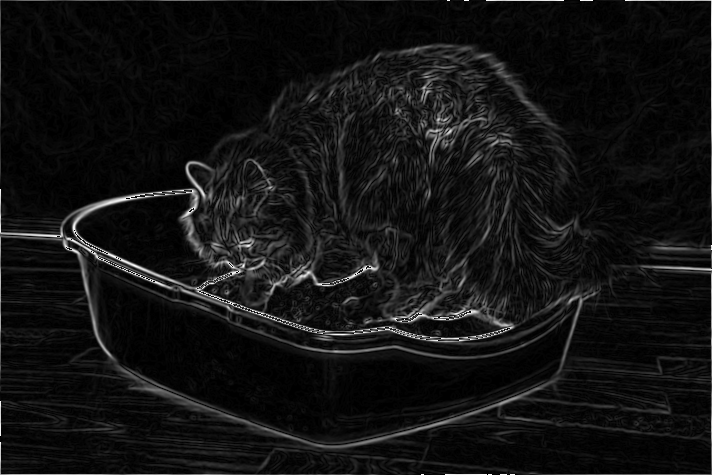

In [145]:
data2, direc = sobel_kernel(data1)
sobel_kernel = Image.fromarray(data2.astype(np.uint8))
display(sobel_kernel)

In [146]:
def round_quad(theta):
    m, n = theta.shape
    theta = theta.tolist()
    for i in range(m):
        for j in range(n):
            theta[i][j] = verif_theta(theta[i][j])
    return theta

def verif_theta(val):
    if -np.pi/8<val<=np.pi/8:
        return np.array([1,0])
    elif np.pi/8<val<=np.pi*3/8:
        return np.array([1,1])
    elif np.pi*3/8<val<=np.pi*5/8:
        return np.array([0,1])
    elif np.pi*5/8<val<=np.pi*7/8:
        return np.array([-1,1])
    elif np.pi*7/8<val or val<=-np.pi*7/8:
        return np.array([-1,0])
    elif -np.pi*7/8<val<=-np.pi*5/8:
        return np.array([-1,-1])
    elif -np.pi*5/8<val<=-np.pi*3/8:
        return np.array([0,-1])
    elif -np.pi*3/8<val<=-np.pi/8:
        return np.array([1,-1])
        

In [147]:
direc = round_quad(direc)

## Aplicando a supressão de não-máximos

In [148]:
def supress_nmax(data, theta):
    ans = np.copy(data)
    counter = 0
    for i in range(1,data.shape[0]-2):
        for j in range(1, data.shape[1]-2):
            gradiente = tuple(np.array([i,j])+theta[i][j])
            n_gradiente = tuple(np.array([i,j])-theta[i][j])
            if data[(i,j)][0]>= data[gradiente][0] and data[(i,j)][0]>= data[n_gradiente][0]:
                pass
            else:
                ans[(i,j)][0] = ans[(i,j)][1] = ans[(i,j)][2] = 0
    return ans

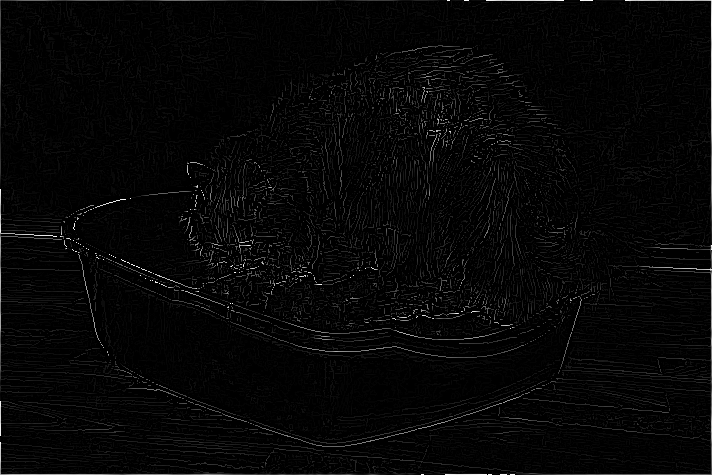

In [149]:
data3 = supress_nmax(data2, direc)
supressed = Image.fromarray(data3.astype(np.uint8))
display(supressed)

## Limite de arestas

In [163]:
def double_treshold(data, t1, t2):
    classif = data[:,:,1]
    ans = np.copy(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[(i,j)][0] < t1:
                ans[(i,j)][0] = ans[(i,j)][1] = ans[(i,j)][2] = 0
                classif[(i,j)] = 0
            elif t1 < data[(i,j)][0] < t2:
                ans[(i,j)][0] = ans[(i,j)][1] = ans[(i,j)][2] = 255
                classif[(i,j)] = 1
            else:
                ans[(i,j)][0] = ans[(i,j)][1] = ans[(i,j)][2] = 255
                classif[(i,j)] = 2
    return ans, classif

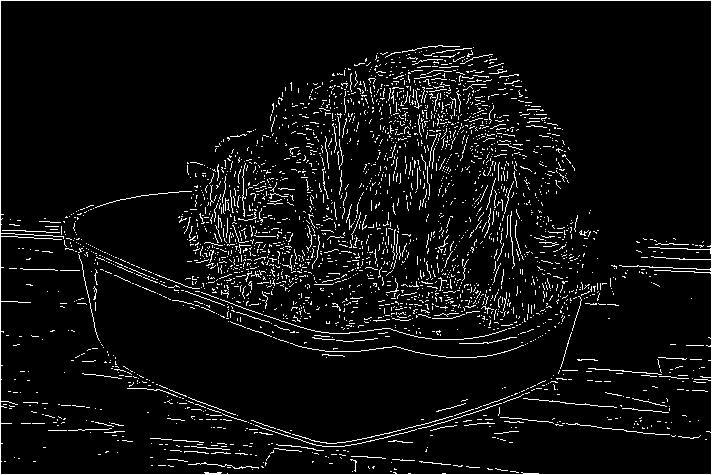

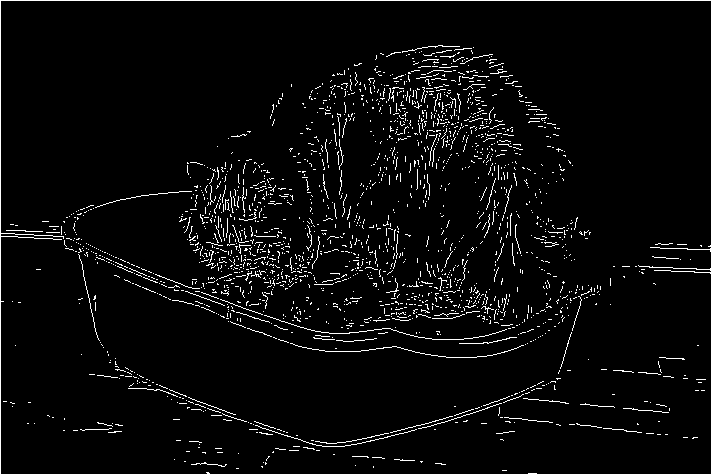

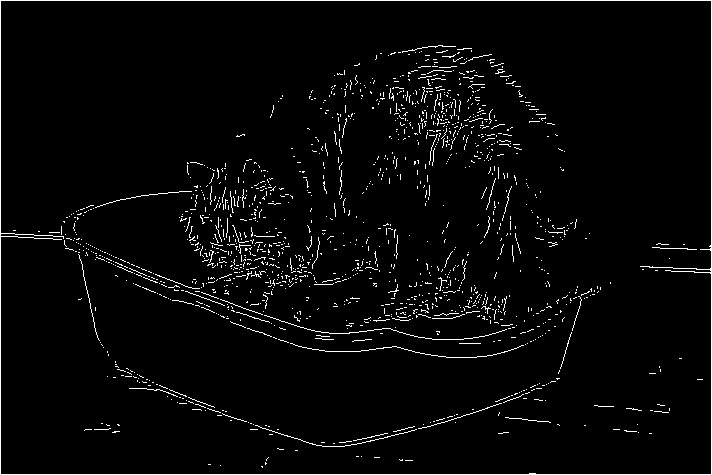

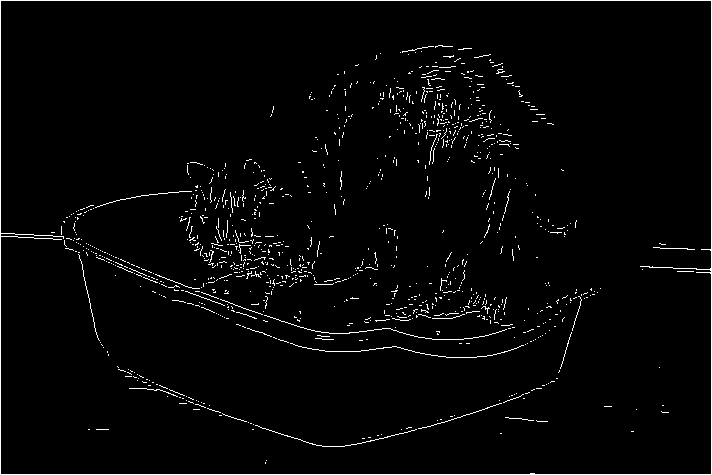

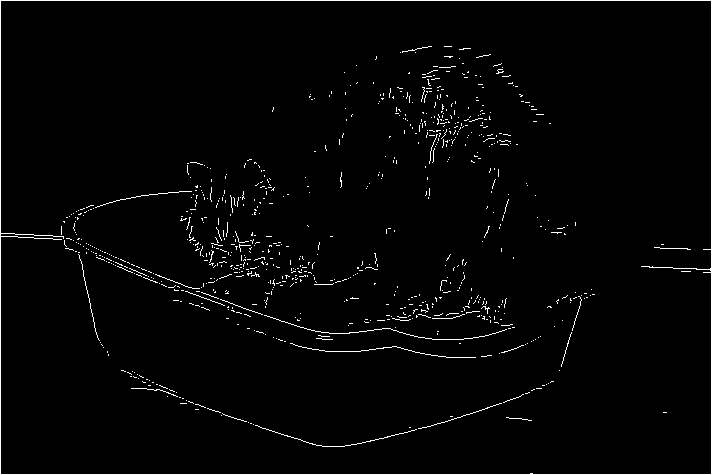

In [172]:
for k in range(30, 80, 10):
    data4, clf = double_treshold(data3, k, 150)
    finished = Image.fromarray(data4.astype(np.uint8))
    display(finished)

## Bibliografia

[Wikipédia](https://en.wikipedia.org/wiki/Canny_edge_detector) - Canny Edge Detector.